In [ ]:
# -----------------------------
# STEP 0: Mount Google Drive
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/DeepLearningDataset"

Mounted at /content/drive


In [ ]:
# -----------------------------
# STEP 1: Remove duplicate images based on content
# -----------------------------
import hashlib

print("Checking for duplicates based on image content...\n")

removed_count = 0

for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    hashes = set()
    total_before = 0
    total_after = 0

    for file_name in os.listdir(class_path):
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            total_before += 1
            file_path = os.path.join(class_path, file_name)
            with open(file_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in hashes:
                os.remove(file_path)
                removed_count += 1
            else:
                hashes.add(file_hash)

    total_after = len(hashes)
    print(f"{class_name}: before={total_before}, after={total_after}")

print(f"\nTotal duplicate images removed: {removed_count}")


Checking for duplicates based on image content...

buildings: before=367, after=367
people: before=423, after=423
laboratories: before=447, after=447
cars : before=400, after=400
trees: before=420, after=420

Total duplicate images removed: 0


In [ ]:
# -----------------------------
# STEP 2: Build DataFrame from folders
# -----------------------------
import pandas as pd

def build_df_from_folders(root_dir):
    rows = []
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for file_name in os.listdir(class_path):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                rows.append({"filename": os.path.join(class_name, file_name), "label": class_name})
    return pd.DataFrame(rows)

df = build_df_from_folders(DATA_DIR)

print("Total images:", len(df))
print("Images per class:\n", df["label"].value_counts())


Total images: 2057
Images per class:
 label
laboratories    447
people          423
trees           420
cars            400
buildings       367
Name: count, dtype: int64


In [ ]:
# -----------------------------
# STEP 3: Train / Validation / Test Split
# -----------------------------
from sklearn.model_selection import train_test_split

SEED = 42

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=SEED
)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Train: 1439
Validation: 309
Test: 309


In [ ]:
# -----------------------------
# STEP 4: Image Preprocessing & Generators
# -----------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=DATA_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=DATA_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=DATA_DIR,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1439 validated image filenames belonging to 5 classes.
Found 309 validated image filenames belonging to 5 classes.
Found 309 validated image filenames belonging to 5 classes.


In [ ]:
# -----------------------------
# STEP 5: Compute Class Weights (Optional)
# -----------------------------
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_labels = train_df["label"].values
classes = np.array(sorted(df["label"].unique()))

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.1198443579766537), 1: np.float64(1.0278571428571428), 2: np.float64(0.9224358974358975), 3: np.float64(0.9722972972972973), 4: np.float64(0.9789115646258504)}


In [ ]:
# -----------------------------
# STEP 6: Build ResNet50 Model
# -----------------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

IMG_SIZE = (224,224)
classes = sorted(df['label'].unique())

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # Freeze base

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# -----------------------------
# STEP 7: Callbacks
# -----------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]


In [ ]:
# -----------------------------
# STEP 8: Train Model
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6792 - loss: 0.9950
Epoch 1: val_accuracy improved from -inf to 0.91909, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 233s 5s/step - accuracy: 0.6819 - loss: 0.9865 - val_accuracy: 0.9191 - val_loss: 0.2244 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9271 - loss: 0.2142
Epoch 2: val_accuracy improved from 0.91909 to 0.94175, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.9271 - loss: 0.2143 - val_accuracy: 0.9417 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9253 - loss: 0.1891
Epoch 3: val_accuracy did not improve from 0.94175
45/45 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.9254 - loss: 0.1892 - val_accuracy: 0.9353 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9336 - loss: 0.2046
Epoch 4: val_accuracy improved fr

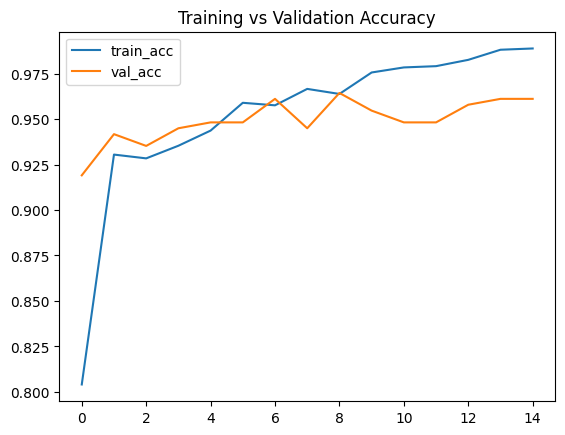

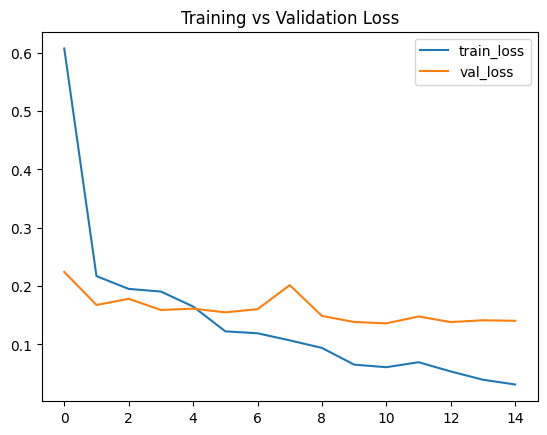

In [ ]:
# -----------------------------
# STEP 9: Plot Training Curves
# -----------------------------
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
# @title Default title text
# -----------------------------
# STEP 10: Evaluate on Test Set
# -----------------------------
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Predict on test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
classes = sorted(df['label'].unique())

# Accuracy
print("Test Accuracy:", accuracy_score(y_true, y_pred_classes))

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
Test Accuracy: 0.970873786407767
Classification Report:
               precision    recall  f1-score   support

   buildings       0.95      0.95      0.95        55
       cars        0.98      0.98      0.98        60
laboratories       1.00      0.99      0.99        68
      people       0.94      1.00      0.97        63
       trees       0.98      0.94      0.96        63

    accuracy                           0.97       309
   macro avg       0.97      0.97      0.97       309
weighted avg       0.97      0.97      0.97       309

Confusion Matrix:
 [[52  0  0  2  1]
 [ 1 59  0  0  0]
 [ 0  0 67  1  0]
 [ 0  0  0 63  0]
 [ 2  1  0  1 59]]
